## 实现方式
- 使用原始数据来构建模型，对数据不做任何处理

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import svm
from sklearn import metrics

In [2]:
np.random.seed(28)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [6]:
stockcode = '000001.SZ'
stockname = '平安银行'
file_path = './data/000001.SZ_day_qfq.csv'
stockfile = pd.read_csv(file_path, index_col='trade_date', parse_dates=True)

In [7]:
stockfile.head(3)

,open,high,low,close,pre_close,change,pct_change,vol,amount
trade_date,,,,,,,,,
2008-01-02,9.81,9.87,9.59,9.68,38.60,-0.62,-1.61,200524.73,7.634657e+05
2008-01-03,9.68,9.70,9.30,9.52,37.98,-0.63,-1.66,275648.31,1.023423e+06
2008-01-04,9.53,9.86,9.52,9.78,37.35,1.02,2.73,198704.38,7.621611e+05


In [8]:
stockfile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 9 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
dtypes: float64(9)
memory usage: 199.3 KB


In [9]:
# 查看索引（2008-01-02~2018-10-31, 间断的时间）
stockfile.index

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2018-10-18', '2018-10-19', '2018-10-22', '2018-10-23',
               '2018-10-24', '2018-10-25', '2018-10-26', '2018-10-29',
               '2018-10-30', '2018-10-31'],
              dtype='datetime64[ns]', name='trade_date', length=2551, freq=None)

在该数据集使用trade_date作为行索引，数据中共有9列，对应的列名以及含义如下：
- open：开盘价
- high：最高价
- low：最低价
- close：收盘价
- pre_close：昨日收盘价
- change：涨跌值
- pct_change：涨跌幅
- vol：成交量（手）
- amount：成交量（千元）

# 可视化K线

In [10]:
def candle_stick(axes, xindex, data, colorup='red', colordown='green'):
    """
        绘制K线
        axes: 绘制图像的pylot对象
        xindex: 索引
        data: 数据DataFrame，要求具有close、open、high、low这四个属性
    """
    up = data['close'] >= data['open']
    down = data['close'] < data['open']
    
    if any(up):
        axes.vlines(xindex[up], data['open'][up], data['close'][up], color=colorup, linewidth=5.5)
        axes.vlines(xindex[up], data['low'][up], data['high'][up], color=colorup, linewidth=1)
    
    if any(down):
        axes.vlines(xindex[down], data['open'][down], data['close'][down], color=colordown, linewidth=5.5)
        axes.vlines(xindex[down], data['low'][down], data['high'][down], color=colordown, linewidth=1)

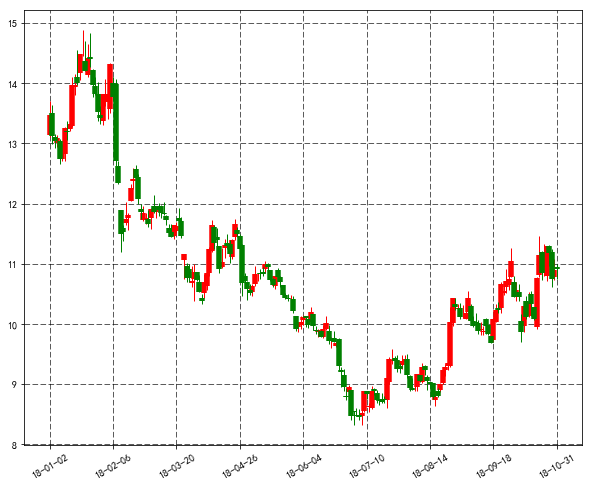

In [11]:
df = stockfile['2018-01-01':]

plt.figure(figsize=(10,8))
axes = plt.gca()
xindex = np.arange(len(df))
# 绘制K线图
candle_stick(axes, xindex, df)
# 给定标签
dates = np.array(df.index.to_pydatetime())
sdates = [date.strftime('%y-%m-%d') for date in dates]
step = len(xindex) // 8
axes.set_xticks(xindex[::step])
axes.set_xticklabels(sdates[::step], rotation=30)
# 画网格
axes.grid(True, ls='--', alpha=0.8, color='k')
plt.show()

# 标注数据
- 假定以收盘价作为买入价，然后持股5日，也以收盘价作为卖出价；那么可以计算出相应的收益

In [12]:
def calc_profit(data, position_period=5):
    """
    计算持仓收益
    """
    price = data['close']
    data['profit'] = (data['close'].shift(-position_period) - price) / price * 100.0

In [13]:
# 计算收益
calc_profit(stockfile)

In [14]:
profit = (stockfile['close'][-1] - stockfile['close'][0]) / stockfile['close'][0]
print("第一天购买，持有十年后卖出，总收益为:%.5f%%" % (profit * 100))

第一天购买，持有十年后卖出，总收益为:12.70661%


count    2546.000000
mean        0.181750
std         5.683024
min       -25.000000
25%        -2.768808
50%        -0.100051
75%         2.791461
max        26.391555
Name: profit, dtype: float64
总收益:95.50768%


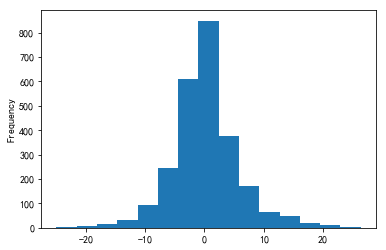

In [15]:
# 收益可视化
stockfile['profit'].plot.hist(15)
# 收益信息数据查看
print(stockfile['profit'].describe())
# 总收益(95%差不多，十年的时间段中, 平均来看)
profit = (((1 + 0.00181750 - 0.0005) ** (2546 / 5)) - 1) * 100
print("总收益:%.5f%%" % profit)

可以看出来，在标注数据的时候，我们可以根据收益情况来进行数据的分类(这里认为是一个二分类，可以做多分类)：
- 收益率大于1%的交易，认为交易是成功的。
- 收益率小于1%的交易，认为交易是失败的。

In [16]:
def calc_profit(data, position_period=5):
    """
    计算持仓收益，并给定标签
    """
    price = data['close']
    data['profit'] = (data['close'].shift(-position_period) - price) / price * 100.0
    data['label'] = 0
    data.loc[data['profit'] > 1.0, 'label'] = 1

In [17]:
# 计算收益并给定标签
calc_profit(stockfile)

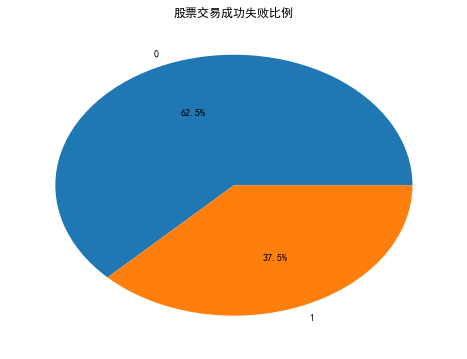

In [18]:
# 可视化（可以发现2/3的失败，1/3成功）
freqs = stockfile['label'].value_counts()
plt.figure(figsize=(8,6))
plt.pie(freqs, labels=freqs.index, autopct='%.1f%%')
plt.title('股票交易成功失败比例')
plt.show()

# 模型构建
- 如果可以发现所有成功的交易位置，那么最终的收益会由多少呢？
- 这里使用SVM算法来预测

In [19]:
# 如果百分百预测正确，那么最终收益是多少呢？
df = stockfile.loc[stockfile['label'] == 1.0, 'profit']
print(df.describe())
# 总收益(95%差不多，十年的时间段中, 平均来看)
profit = (((1 + 0.05420901 - 0.0005) ** (df.shape[0] // 5)) - 1) * 100
print("总收益:%.5f%%" % profit)

count    957.000000
mean       5.420901
std        4.455944
min        1.006192
25%        2.283105
50%        3.914989
75%        7.134894
max       26.391555
Name: profit, dtype: float64
总收益:2185911.68670%


基于SVM的初始模型构建

- 获取训练用数据和测试用数据

In [20]:
stockfile.info()
stock_data = stockfile.drop(['pre_close', 'change', 'pct_change', 
                    'vol', 'amount', 'profit'], axis=1)
stock_data.info()

split_idx = int(4.0 * stock_data.shape[0] / 5)
stock_train_data, stock_test_data = stock_data.iloc[:split_idx,:], stock_data.iloc[split_idx:, :]
print("训练数据格式:{}, 测试数据格式:{}".format(stock_train_data.shape, stock_test_data.shape))

# 获取收盘价
buy_price = stockfile['close']
train_data_buy_price = buy_price[:split_idx]
test_data_buy_price = buy_price[split_idx:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 11 columns):
open          2551 non-null float64
high          2551 non-null float64
low           2551 non-null float64
close         2551 non-null float64
pre_close     2551 non-null float64
change        2551 non-null float64
pct_change    2551 non-null float64
vol           2551 non-null float64
amount        2551 non-null float64
profit        2546 non-null float64
label         2551 non-null int64
dtypes: float64(10), int64(1)
memory usage: 319.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2008-01-02 to 2018-10-31
Data columns (total 5 columns):
open     2551 non-null float64
high     2551 non-null float64
low      2551 non-null float64
close    2551 non-null float64
label    2551 non-null int64
dtypes: float64(4), int64(1)
memory usage: 199.6 KB
训练数据格式:(2040, 5), 测试数据格式:(511, 5)


* 拆分训练集和测试集

In [21]:
X = stock_data.drop('label', axis=1)
Y = stock_data['label']
x_train = stock_train_data.drop('label', axis=1)
x_test = stock_test_data.drop('label', axis=1)
y_train = stock_train_data['label']
y_test = stock_test_data['label']
print("训练数据格式:{}, 测试数据格式:{}".format(x_train.shape, x_test.shape))

训练数据格式:(2040, 4), 测试数据格式:(511, 4)


- 模型训练

In [22]:
algo = svm.SVC(probability=True)
algo.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

- 模型效果评估

In [23]:
y_pred_test = algo.predict(x_test)
y_pred_train = algo.predict(x_train)
y_pred_all = algo.predict(X)
print("训练数据准确率:{}".format(metrics.accuracy_score(y_train, y_pred_train)))
print("测试数据准确率:{}".format(metrics.accuracy_score(y_test, y_pred_test)))
print("训练数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_train, y_pred_train)))
print("训练数据的效果report:\n{}".format(metrics.classification_report(y_train, y_pred_train)))
print("测试数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(y_test, y_pred_test)))
print("测试数据的效果report:\n{}".format(metrics.classification_report(y_test, y_pred_test)))
print("所有数据准确率:{}".format(metrics.accuracy_score(Y, y_pred_all)))
print("所有数据的效果混淆矩阵:\n{}".format(metrics.confusion_matrix(Y, y_pred_all)))
print("所有数据的效果report:\n{}".format(metrics.classification_report(Y, y_pred_all)))


训练数据准确率:0.6254901960784314
测试数据准确率:0.6516634050880626
训练数据的效果混淆矩阵:
[[1256    5]
 [ 759   20]]
训练数据的效果report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1261
           1       0.80      0.03      0.05       779

   micro avg       0.63      0.63      0.63      2040
   macro avg       0.71      0.51      0.41      2040
weighted avg       0.69      0.63      0.49      2040

测试数据的效果混淆矩阵:
[[333   0]
 [178   0]]
测试数据的效果report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       333
           1       0.00      0.00      0.00       178

   micro avg       0.65      0.65      0.65       511
   macro avg       0.33      0.50      0.39       511
weighted avg       0.42      0.65      0.51       511

所有数据准确率:0.630733045864367
所有数据的效果混淆矩阵:
[[1589    5]
 [ 937   20]]
所有数据的效果report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1

#### 计算在当前模型情况下的，最终效果

In [24]:
def calc_rate_of_return_by_state(buy_price, buy_infos, initial_capital=100000.0):
    """
    buy_infos: 购买信息，True表示购买，False表示卖出
    :param buy_price: 价格信息
    :param buy_infos:
    :param initial_capital: 初始资本
    :return:
    """
    # 资本
    capital = initial_capital
    # 持有的股本
    hold_equity = 0.0

    flag = False
    for idx, buy_flag in enumerate(buy_infos):
        if buy_flag:
            # 当需要进行购买操作的时候，两种情况：如果之前就是购买，那就继续持有；否则全部买入
            if not flag:
                # 买入
                hold_equity = 1.0 * capital / buy_price[idx]
                flag = True
                capital = 0.0
        else:
            # 当需要进行卖出操作的时候，两种情况：如果之前就是卖出, 那么继续不买入；否则卖出
            if flag:
                # 卖出
                flag = False
                capital = hold_equity * buy_price[idx]
                hold_equity = 0.0

    # 计算最终的金额以及收益率
    total_capital = capital + hold_equity * buy_price[-1]
    return total_capital, (total_capital - initial_capital) / initial_capital


In [25]:
print("所有数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_all.astype(np.bool)
print(calc_rate_of_return_by_state(buy_price, buy_infos))

所有数据上
原始随机情况下:
(124615.43419521823, 0.2461543419521823)
模型预测情况下:
(155984.8406132475, 0.5598484061324751)


In [26]:
print("训练数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(train_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_train.astype(np.bool)
print(calc_rate_of_return_by_state(train_data_buy_price, buy_infos))

训练数据上
原始随机情况下:
(97989.39091047984, -0.02010609089520163)
模型预测情况下:
(155984.8406132475, 0.5598484061324751)


In [27]:
print("测试数据上")
print("原始随机情况下:")
buy_infos = np.ones_like(test_data_buy_price, dtype=np.bool)
buy_infos[::5] = False
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))
print("模型预测情况下:")
buy_infos = y_pred_test.astype(np.bool)
print(calc_rate_of_return_by_state(test_data_buy_price, buy_infos))

测试数据上
原始随机情况下:
(127315.7470851489, 0.27315747085148906)
模型预测情况下:
(100000.0, 0.0)
